# 프로젝트 : Pretrained model의 활용  

목표 : Pretrained Model 사용해 보기

`Step 설명 : 이제 본격적으로 pretrained model을 활용해 보겠습니다. 사용해야 할 모델 구조나 데이터셋 구조, 배치 구조는 이전 스텝과 동일합니다. 다음 안내를 따라 이미 다운로드한 pretrained model을 활용하는 학습을 다시 진행해 봅시다.`



## STEP 0. 데이터 와 BERT 구성 함수 준비

### 데이터셋 로드

In [1]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/bert_qna/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_qna/models'

이미 전처리된 데이터를 가져옴

In [3]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [5]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

True

Validataion data 중 한 개를 확인해 봄

In [29]:
# dev_json 중 한개 데이터 확인
with open(dev_json) as f:
    for i, line in enumerate(f):
        if i == 5:
            d = json.loads(line)
            q = vocab.decode_pieces(d['question'])
            c = vocab.decode_pieces(d['context'])
            a = d['answer']
            print(f"[question] : {q}")
            print(f"[context] : {c}")
            print(f"[answer] : {a}")

[question] : 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 사람의 이름은?
[context] : 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
[answer] : 임종석


In [30]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [31]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_seq_length': 384, 'max_query_length': 64}

In [32]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: |          | 0/? [00:00<?, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: |          | 0/? [00:00<?, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

### BERT를 구성하기 위한 함수들

In [10]:
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [11]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [12]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

스케일닷프러덕트

In [13]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

멀티헤드어텐션

In [14]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [15]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [16]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

BERT 구성

In [17]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

## STEP 1. pretrained model 로딩하기
`Step 설명 : pretrained model을 로드하여 model을 생성하는 코드는 아래와 같습니다. model 구조는 이전 스텝과 동일합니다.`

BERT 모델 호출 class

In [18]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

하이퍼파라미터 설정

In [19]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

데이터셋 분리

In [20]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [21]:
# pretrained model을 로드하여 model을 생성하는 코드
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')


Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  10662400  
_________________________________________________________________
dense_18 (Dense)             multiple                  514       
Total params: 10,662,914
Trainable params: 10,662,914
Non-trainable params: 0
_________________________________________________________________


## STEP 2. pretrained model finetune 하기
`Step 설명 : 학습을 진행하는 코드도 이전 스텝과 동일합니다. 단지 학습해야 할 모델이 랜덤 초기화된 것이 아니라 pretrained model을 로드한 것일 뿐입니다.`

학습 진행 metric 출력

In [22]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [23]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

epoch에 따라 학습진행

In [24]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
p_tr_loss, p_tr_start_acc, p_tr_end_acc, p_val_loss, p_val_start_acc, p_val_end_acc = [],[],[],[],[],[]
for epoch in range(20):
    tr_start_loss, tr_end_loss, tr_start_acc, tr_end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    
    p_tr_loss.append(tr_start_loss + tr_end_loss)
    p_tr_start_acc.append(tr_start_acc)
    p_tr_end_acc.append(tr_end_acc)
    
    p_val_loss.append(start_loss + end_loss)
    p_val_start_acc.append(start_acc)
    p_val_end_acc.append(end_acc)
    
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

|          | 0/? [00:00<?, ?it/s]

eval 0 >> loss: 3.6868, 4.2689, acc: 0.1261, 0.1001
save best model


|          | 0/? [00:00<?, ?it/s]

eval 1 >> loss: 3.5582, 4.1519, acc: 0.1517, 0.1336
save best model


|          | 0/? [00:00<?, ?it/s]

eval 2 >> loss: 3.6766, 4.3638, acc: 0.1636, 0.1466
save best model


|          | 0/? [00:00<?, ?it/s]

eval 3 >> loss: 3.7155, 4.3142, acc: 0.1638, 0.1447


|          | 0/? [00:00<?, ?it/s]

eval 4 >> loss: 3.9132, 4.6740, acc: 0.1596, 0.1429


|          | 0/? [00:00<?, ?it/s]

eval 5 >> loss: 4.0009, 4.7740, acc: 0.1566, 0.1355


|          | 0/? [00:00<?, ?it/s]

eval 6 >> loss: 4.4207, 5.1470, acc: 0.1520, 0.1399


|          | 0/? [00:00<?, ?it/s]

eval 7 >> loss: 5.1261, 5.7393, acc: 0.1394, 0.1303
early stopping


## STEP 3. Inference 수행하기
`Step 설명 : finetune 학습이 완료된 model을 활용하여 실제 퀴즈 풀이 결과를 확인해 봅니다.`

예측 결과 확인하기

In [26]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

### 퀴즈 0 : validation 데이터

In [35]:
print(q)
print(a)

1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 사람의 이름은?
임종석


In [33]:
do_predict(model, q, c)

'임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은'

잘 예측하지 못한 거 같다. 정답은 '임종석'인데 엉뚱한 결과가 나왔다. 

### 퀴즈 1 : 새로운 데이터

In [46]:
question1 = "고양이 눈 성운은 누가 발견했나?"

In [47]:
context1 = "고양이 눈 성운(Cat's Eye Nebula, NGC 6543)은 용자리에 있는 행성상 성운이다. 이 성운은 지금까지 알려진 성운들 중 구조가 가장 복잡한 성운 중 하나이며, 허블 우주 망원경에 의한 고해상도 촬영에서 매듭·제트·거품·원호 모양 등의 주목할 만한 구조들이 발견되었다. 고양이 눈의 중심에는 밝고 뜨거운 항성이 있는데, 이 별은 약 1000년 전에 자신의 겉 표면을 날려버리고 성운을 형성했다. 고양이 눈 성운은 1786년에 윌리엄 허셜이 발견하였고, 1864년엔 영국의 아마추어 천문학자 윌리엄 허긴스가 스펙트럼을 관측함으로써 행성상 성운 중 최초로 분광학적 연구가 수행되었다. 허긴스의 연구 결과, 행성상 성운이 뜨거운 기체로 이루어진 천체이며 항성이 아니라는 것이 최초로 증명되었다. 성운의 복잡한 구조 중 일부는 연성계의 중심별에서 물질이 방출되면서 만들어졌을 것으로 생각되지만, 중심별이 동반성을 가지고 있었다는 직접적 증거는 아직 나오지 않았다. 허블 망원경의 관측에서는 오래 전에 중심별에서 분출된 구형의 껍질이 고양이 눈 모양 주위로 다수의 희미한 고리 구조를 이루는 것이 관찰되었으나, 이런 분출이 어떻게 이루어지는지 정확한 메커니즘 역시 밝혀지지 않았다."

In [48]:
do_predict(model, question1, context1)

'윌리엄 허셜이 발견하였고, 1864년엔 영국의 아마추어 천문학자 윌리엄 허긴스가 스펙트럼을 관측함으로써 행성상 성운 중 최초로 분광학적 연구가 수행되었다. 허긴스의'

허셜을 기대했으나, 잘 예측하지 못한 거 같다. 

### 퀴즈 2 : 새로운 데이터 

In [39]:
question2 = "경복궁의 의미는?"

In [40]:
context2 = "조선 왕조 개국 3년인 1395년에 완공된 궁궐은 390여 칸으로 한양의 중심축에 자리했다. 개국공신 정도전은 태조로부터 첫 번째 궁궐의 이름을 지으라는 명을 받았고, 고심 끝에 '새 왕조가 큰 복을 누려 번영할 것'이라는 의미로 경복궁(景福宮)이라는 이름을 붙였다. 국보 제223호인 근정전(勤政殿)은 경복궁의 법전으로 각종 즉위식을 거행했던 왕실의 행사장이었다. 근정전의 옆에 위치한 경회루는 1만원권 구화폐 실릴 만큼 대표적인 건축물로 사랑받아 왔다. 이외에도 일제강점기에 훼손을 겪었다가 2010년에 완전히 복원된 광화문, 고종과 명성황후가 머물던 건천궁, 경복궁의 후원인 향원정 등이 자리하고 있다. 경복궁은 조선 왕조 최고의 궁궐인 만큼 생각보다 넓다. 동선은 자유롭게 조정할 수 있다. 다만 좀 더 자세한 관람을 원한다면 우리궁궐지킴이 해설사들의 설명과 함께하는 것이 가장 좋다. 경복궁과 서촌 지역 방문 관람객의 편의를 높이고 경제 활성화를 위한 경복궁의 서문 영추문이 2018년 12월부터 전면 개방된다. 경복궁 출입문은 이전까지 남쪽의 광화문, 북쪽의 신무문, 동쪽의 국립민속박물관 출입문 등 총 세 곳으로 이번에 서쪽의 영추문을 43년 만에 개방하면서 동·서·남·북 모든 곳에서 출입이 가능해진다."

In [41]:
do_predict(model, question2, context2)

"'새 왕조가 큰 복을 누려 번영할 것'이라는 의미로 경복궁(景福宮)이라는"

의미는 추출해냈으나 깔끔하게 나온건 아니다. 

## STEP 4. 학습 경과 시각화 비교분석
`Step 설명 : pretrained model 사용 여부에 따라 학습 수행 경과가 어떻게 달라지는지를 시각화를 포함하여 비교분석을 진행해 봅니다. `  

none pretrained model 학습결과 확인하기

In [43]:
model = BERT4KorQuAD(config)

enc_tokens = np.random.randint(0, len(vocab), (4, 10))
segments = np.random.randint(0, 2, (4, 10))
model(enc_tokens, segments)

model.summary()

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  10662400  
_________________________________________________________________
dense_37 (Dense)             multiple                  514       
Total params: 10,662,914
Trainable params: 10,662,914
Non-trainable params: 0
_________________________________________________________________


In [44]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
n_tr_loss, n_tr_start_acc, n_tr_end_acc, n_val_loss, n_val_start_acc, n_val_end_acc = [],[],[],[],[],[]
for epoch in range(20):
    tr_start_loss, tr_end_loss, tr_start_acc, tr_end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    
    n_tr_loss.append(tr_start_loss + tr_end_loss)
    n_tr_start_acc.append(tr_start_acc)
    n_tr_end_acc.append(tr_end_acc)
    
    n_val_loss.append(start_loss + end_loss)
    n_val_start_acc.append(start_acc)
    n_val_end_acc.append(end_acc)
    
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

|          | 0/? [00:00<?, ?it/s]

eval 0 >> loss: 3.6857, 4.2688, acc: 0.1289, 0.1067
save best model


|          | 0/? [00:00<?, ?it/s]

eval 1 >> loss: 3.6594, 4.0817, acc: 0.1575, 0.1382
save best model


|          | 0/? [00:00<?, ?it/s]

eval 2 >> loss: 3.6317, 4.1432, acc: 0.1591, 0.1412
save best model


|          | 0/? [00:00<?, ?it/s]

eval 3 >> loss: 3.5836, 4.1248, acc: 0.1634, 0.1464
save best model


|          | 0/? [00:00<?, ?it/s]

eval 4 >> loss: 3.7886, 4.4092, acc: 0.1640, 0.1478
save best model


|          | 0/? [00:00<?, ?it/s]

eval 5 >> loss: 3.8655, 4.3958, acc: 0.1548, 0.1457


|          | 0/? [00:00<?, ?it/s]

eval 6 >> loss: 4.1228, 4.7013, acc: 0.1620, 0.1429


|          | 0/? [00:00<?, ?it/s]

eval 7 >> loss: 4.2516, 5.0187, acc: 0.1522, 0.1445


|          | 0/? [00:00<?, ?it/s]

eval 8 >> loss: 4.5052, 5.1370, acc: 0.1454, 0.1397


|          | 0/? [00:00<?, ?it/s]

eval 9 >> loss: 4.9017, 5.3770, acc: 0.1385, 0.1325
early stopping


### Pretrained Model 사용 시각화

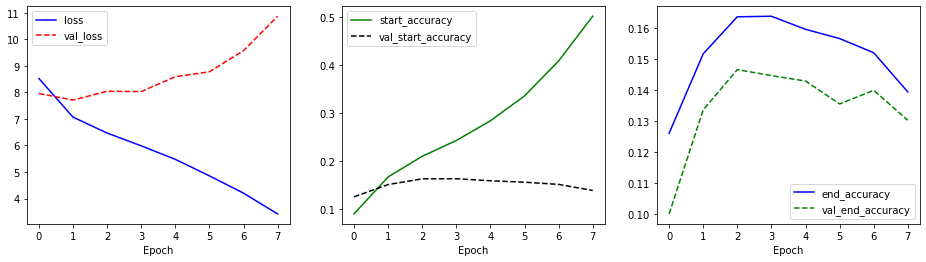

In [42]:
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(p_tr_loss, 'b-', label='loss')
plt.plot(p_val_loss, 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(p_tr_start_acc, 'g-', label='tart_accuracy')
plt.plot(p_val_start_acc, 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(p_val_start_acc, 'b-', label='end_accuracy')
plt.plot(p_val_end_acc, 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

### None Pretrained Model 사용 시각화

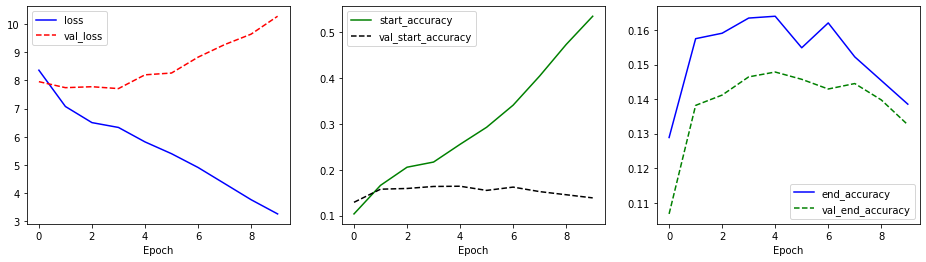

In [45]:
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(n_tr_loss, 'b-', label='loss')
plt.plot(n_val_loss, 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(n_tr_start_acc, 'g-', label='start_accuracy')
plt.plot(n_val_start_acc, 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(n_val_start_acc, 'b-', label='end_accuracy')
plt.plot(n_val_end_acc, 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

pretrained model과 none pretrained model을 비교해봤을 때 어떤 것이 나아졌는지 확인하기 힘들다. 
validation loss가 낮아지지 않았다. 정확도에서는 약간 pretrained model이 나아보인다. 

## 느낀점

pretrained model을 사용해 BERT를 배우는 시간이였다.    
BERT는 전체적인 파라미터 수는 커졌지만, 기본적인 구조는 Transformer와 동일하다. Transformer Encoder 구조만을 활용한 것이다.    
노드를 배울 때마다 새로운 기술이 나와서 당황스럽다. Transformer를 배울 때 이게 최종인가보다 했는데, 또 BERT가 나오다니...   
이번 프로젝트에서 시각화를 어떻게 할지 한 참을 고민했다. 코드가 조금만 달라져도 어떻게 할지 감이 잡히지 않는다.    
학습노드에서 사용한 LSTM모델에 시각화한 코드를 썼다. 알고보면 별거 아닌데, 잘 생각이 나질 않는다.   
정답이 없으니, 내가 맞게 하고 있나 늘 의구심이 든다.   
이번 노드에서 BERT 대해 완벽히 알지는 못한거 같다.   